<a href="https://colab.research.google.com/github/y33-j3T/TensorFlow/blob/master/Predicting_fuel_efficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predict fuel efficiency

## Install and import depencencies

In [29]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


## Import Auto MPG dataset

### Overview of [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset

Number of Instances: 398

Number of Attributes: 9 including the class attribute

Attribute Information:

    1. mpg:           continuous
    2. cylinders:     multi-valued discrete
    3. displacement:  continuous
    4. horsepower:    continuous
    5. weight:        continuous
    6. acceleration:  continuous
    7. model year:    multi-valued discrete
    8. origin:        multi-valued discrete
    9. car name:      string (unique for each instance)

Missing Attribute Values:  horsepower has 6 missing values

Full data set description can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.names).

Full data folder can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/).



### Get the data
Download the dataset.

In [30]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [31]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values="?",
                          comment='\t', sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


### Clean the data
As mentioned above, the data set contains a few unknown values

In [32]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

The number of rows with unknown values is relatively few, hence it is safe to drop them.

In [0]:
dataset = dataset.dropna()

The `Origin` column is really categorical, not numeric. So convert that to one-hot. (According to TensorFlow tutorial, I'll find out how do they know this later on)

In [0]:
origin = dataset.pop('Origin')

In [35]:
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0


### Split the data into train and test set

In [0]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data
Have a quick look at the joint distribution of a few pairs of columns from the training set.

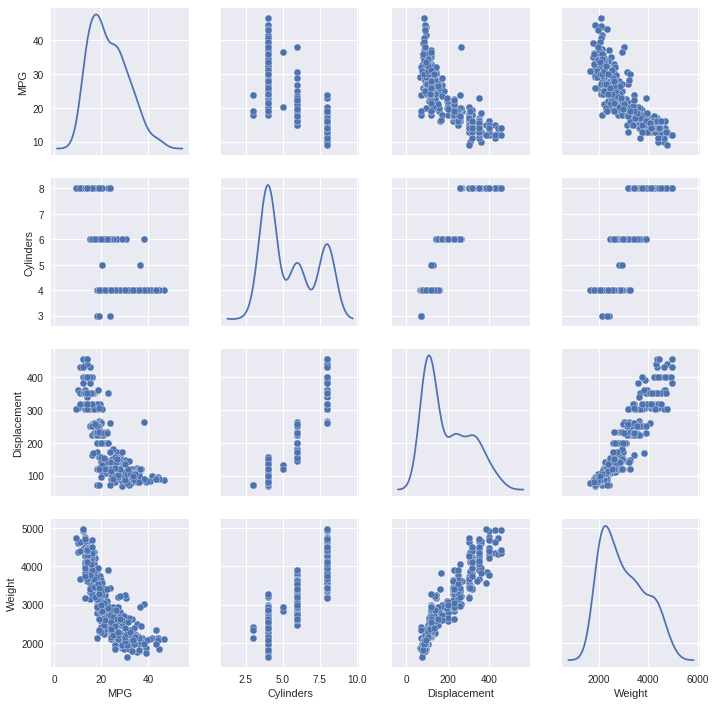

In [37]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Also look at the overall statistics.

In [38]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.T
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.531847,1.729449,3.0,4.000,4.0,8.00,8.0
Displacement,314.0,197.855096,106.501896,68.0,105.000,151.0,302.00,455.0
Horsepower,314.0,105.971338,39.636557,46.0,76.000,95.0,130.00,230.0
Weight,314.0,3005.745223,859.060925,1649.0,2231.000,2831.5,3641.75,4955.0
Acceleration,314.0,15.510828,2.803560,8.0,13.625,15.5,17.00,24.8
Model Year,314.0,75.910828,3.688989,70.0,73.000,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.000,1.0,1.00,1.0
Europe,314.0,0.171975,0.377961,0.0,0.000,0.0,0.00,1.0
Japan,314.0,0.203822,0.403481,0.0,0.000,0.0,0.00,1.0


### Split features from labels

In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize the data
It is good practice to normalize features that use different scales and ranges. Although the model might coverage without feature normalizaition, it **makes training more difficult**, and it **makes the resulting model dependent on the choice of unit**s used to input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier. That includes the test set as well as live data when the model is used in production.

## The model

In [0]:
def build_model():
  model = keras.Sequential([
      layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
      layers.Dense(64, activation=tf.nn.relu),
      layers.Dense(1)
  ])
  
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  
  return model

In [0]:
model = build_model()

### Inspect the model

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


### Try out the model

In [44]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.01202856],
       [0.32671478],
       [0.6891249 ],
       [0.3645356 ],
       [0.16081867],
       [0.59905195],
       [0.3625175 ],
       [0.5445525 ],
       [0.11205335],
       [0.09896433]], dtype=float32)

### Train the model
Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [45]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')
       
EPOCHS = 1000
       
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                         validation_split=0.2, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [46]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,3.091858,1.152633,3.091858,4.061643,1.655349,4.061643,995
996,2.931286,1.129895,2.931286,4.140306,1.666621,4.140306,996
997,2.810225,1.110264,2.810225,4.287649,1.645738,4.287649,997
998,3.111419,1.159885,3.111419,4.452469,1.682845,4.452470,998
999,2.843152,1.111813,2.843152,4.357810,1.704925,4.357810,999


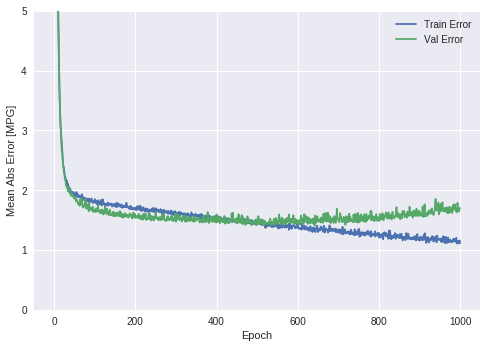

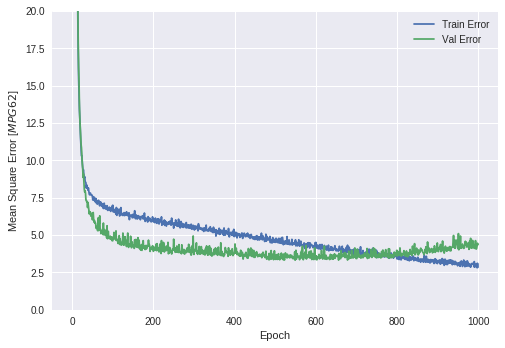

In [47]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label='Val Error')
  plt.ylim([0, 5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG62$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'], label='Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()
  
plot_history(history)

This graph shows little improvement, or even degradation in the validation error after about 100 epochs.  To tackle this, we need to update `model.fit` to automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping* callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training. 

You can learn more about this callback [here](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).


.............................................................................................

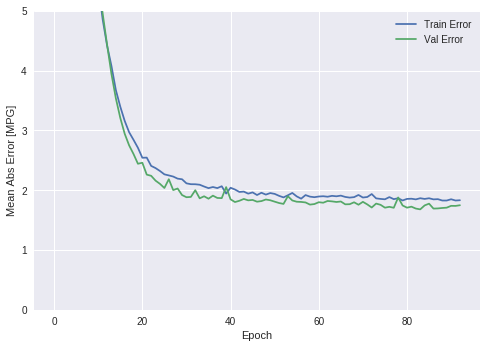

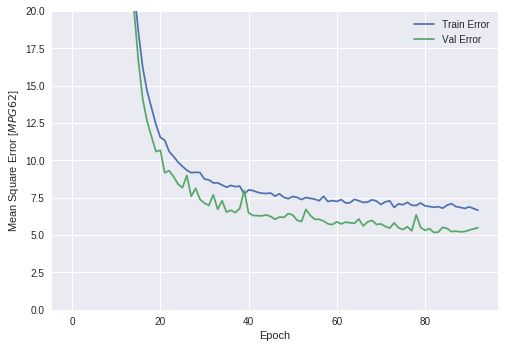

In [49]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0, 
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

Let's see how well the model generalizes by using the test set, which we did not use when training the model. This tells us how well we can expect the model to predict when we use it in the real world.

In [50]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.93 MPG


### Make predictions


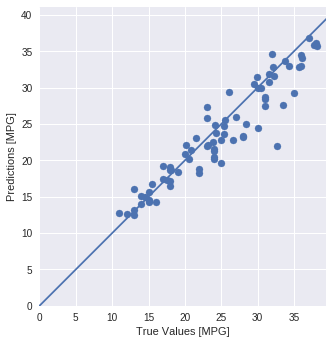

In [51]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


It looks like our model predicts reasonably well. Let's take a look at the error distribution.

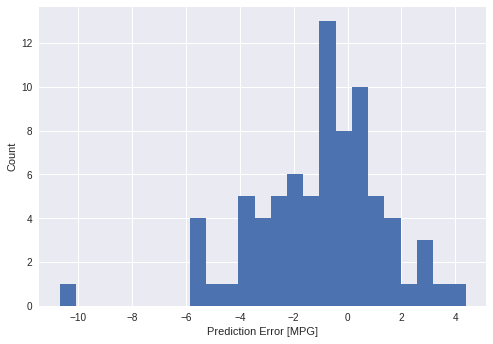

In [52]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

It's not quite gaussian, but we might expect that because the number of samples is very small.

## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.